In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import netCDF4 as nc

fpath = './data/ndvi3g_geo_v1_2010_0106.nc4'
ncfile = nc.Dataset(fpath, 'r')

lon, lat = ncfile.variables['lon'][:], ncfile.variables['lat'][:]
latid = np.where((lat>=30.) * (lat<=80.))
lat = lat[latid]
yy0, yy1 = latid[0][0], latid[0][-1]+1

# NDVI data of June
ndvi = ncfile.variables['ndvi'][::2,yy0:yy1,:]/10000.
ndvi = ndvi[-1]
print(ndvi.shape)

# data out proper range > missing value
idx = np.where((ndvi<-0.3) + (ndvi>1.0))
ndvi[idx] = np.nan

(600, 4320)


c:\Users\admin\.conda\envs\clim\lib\site-packages\ipykernel_launcher.py:24: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type


c:\Users\admin\.conda\envs\clim\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


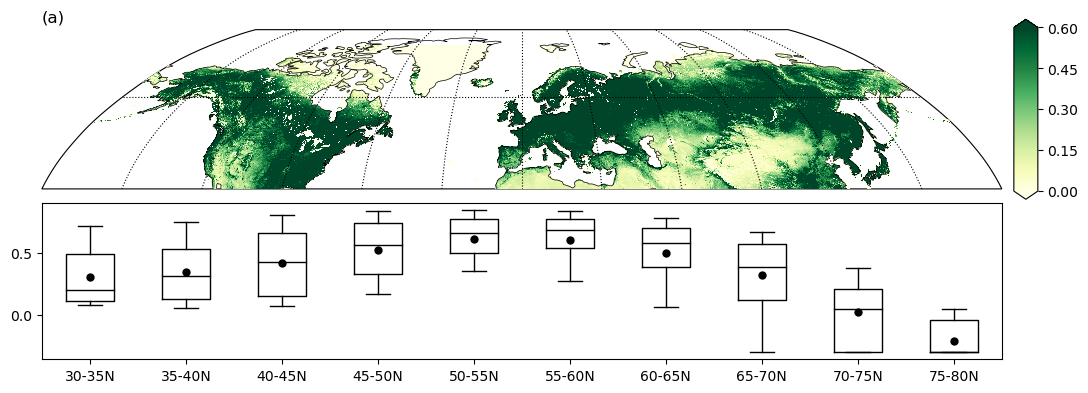

In [3]:
projection_type = ccrs.Robinson(central_longitude=0.)
minlon, maxlon, minlat, maxlat = -180., 180., 30., 90.

fig = plt.figure(figsize=(12,4), dpi=100)
gs0 = gridspec.GridSpec(1,1, left=0.1, right=0.90, top=0.95, bottom=0.5)
ax0 = plt.subplot(gs0[0], projection=projection_type)
# gridspec()을 이용해 공간분포용 서브플롯 위치 잡기

cgs = gridspec.GridSpec(1, 1, left=0.91, right=0.93, top=0.95, bottom=0.5)
cax0 = plt.subplot(cgs[0])  # 컬러바를 위한 서브플롯 선언

gs1 = gridspec.GridSpec(1,1, left=0.1, right=0.90, top=0.49, bottom=0.1)
ax1 = plt.subplot(gs1[0])   # 상자수염도를 위한 서브플롯 위치 잡기

minr, maxr = 0., 0.6    # 공간분포 그림을 위한 NDVI 최솟값 및 최댓값 설정
lon2d, lat2d = np.meshgrid(lon, lat)

ax0.set_extent([minlon, maxlon, minlat, maxlat],
               crs = ccrs.PlateCarree())    # ax0에 공간범위 설정

# NDVI 공간분포 그리기
cs = ax0.pcolormesh(lon2d, lat2d, ndvi, cmap='YlGn',
                    transform=ccrs.PlateCarree(),
                    vmin=minr, vmax=maxr, zorder=4)
# 위경도선 그리기
ax0.gridlines(crs=ccrs.PlateCarree(), color='k',
              xlocs=np.arange(-180,180+30,30), ylocs=np.arange(-90.,90.1,30.),
              linestyle=':', zorder=7)
ax0.coastlines(linewidth=0.5, zorder=7)     # 해안선
ax0.set_title('(a)', loc='left')    # 그림 번호 라벨링

clevs = np.linspace(minr, maxr, 5)  # 컬러바를 위한 레벨 생성
cbar = plt.colorbar(cs, extend='both', cax=cax0, ticks=clevs, orientation='vertical')


# 상자수염도에 리스트 혹은 행렬 데이터를 입력하면
# 해당 데이터 및 옵션을 바탕으로 통계값을 산정하여 그림에 반영
# 여기서는 datadict라는 이름의 딕셔너리를 생성, 데이터를 집어넣어 plt.boxplot()에 입력

# NDVI와 동일한 차원을 가지는 latcode 행렬 생성
# latcode에 각 지역의 위도에 따른 인덱스 부여
# 상자수염도를 그릴 때에 해당 인덱스를 이용하여 각 위도 범위의 자료를 불러오는 데에 이용

# 이와 같은 방법을 응용해 특정 국가나 특정 지면 유형 등을 대상으로
# 지역별/유형별 상자수염도를 쉽게 그릴 수 있음
# * 단순히 위도 범위에 따르는 것은 np.where()가 편하지만,
#   지역 선정 기준이 복잡한 경우 인덱스 행렬을 생성/이용하여 진행하는 방식이 쉬움
#   (ex. 특정 국가나 지역, 식생 유형 등)
# 여기에서는 편의상 위도 범위를 이용하여 인덱스를 이하와 같이 생성

datadict = {}
latcode = np.copy(ndvi)
for ii in range(10):
    lat0 = 30. + ii*5
    lat1 = 30. + (ii+1)*5.
    latid = np.where((lat>=lat0) * (lat<lat1))[0]
    yy0, yy1 = latid[0], latid[-1]+1    # 해당 구간의 경도 인덱스 파악
    latcode[yy0:yy1,:] = ii     # 해당 구간에 ii값 부여
    
    bandname = format(lat0, '2.0f') + '-' + format(lat1, '2.0f') + 'N'  # 각 위도 구간의 이름 생성
    idx = np.where((latcode==ii) * ~np.isnan(ndvi))
    # latcode가 ii이며 ndvi가 nan이 아닌 지점 파악
    datadict[bandname] = ndvi[idx]
    # datadict 행렬을 대상으로 위도 구간의 이름(bandname)에
    # 조건을 만족하는 해당 위도 구간의 데이터를 할당

ax1.boxplot(list(datadict.values()), showfliers=False, whis=[10,90],
            medianprops={'color':'k'}, showmeans=True,
            meanprops={'markerfacecolor':'k', 'markeredgecolor':'None', 'marker':'o'})
ax1.set_xticklabels(list(datadict.keys()))

plt.show()
